In [1]:
# !pip uninstall --yes fastcore && pip install --upgrade git+git://github.com/fastai/fastcore.git 

In [2]:
# !pip uninstall --yes fastai2 && pip install --upgrade git+git://github.com/fastai/fastai2.git

In [3]:
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.text.all import *
torch.cuda.set_device(0)

In [4]:
bs = 40
wd = 1e-1
moms = (0.95, 0.85, 0.95)#(0.8,0.7,0.8)#
seq_len = 72

In [5]:
lang = 'he'
data_path = Config.config_path/'data'
name = f'{lang}wiki'
tok = 'SP_data_fwd'
text_path = data_path/name
path = Path(f'{data_path}/{name}_{tok}')
data_format = 'token' #morph or token
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt_{tok}', f'{lang}_wt_vocab_{tok}']

In [6]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [7]:
counter = pickle.load(open(str(path/'counter.pkl'), 'rb'))
vocab = make_vocab(counter)
len(vocab)

7984

In [8]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df['is_valid'] = False
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df['is_valid'] = True
df = pd.concat([train_df,test_df], sort=False).rename(columns={'comment': 'text'})
df = df.drop_duplicates('text')
df = df[df.label != 2]
train_df = df[df.is_valid == False]
test_df = df[df.is_valid == True]
len(train_df), len(test_df)

(7278, 1103)

In [9]:
# splits = ColSplitter()(df)
# x_tfms = [attrgetter('text'),
#         Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
#         Numericalize(vocab)]
# dsrc = Datasets(df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
# cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
#                            cache=2048, num_workers=8, pin_memory=True)

In [10]:
splits = RandomSplitter(0.5, seed=42)(train_df)
x_tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
dsrc = Datasets(train_df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
                           cache=2048, num_workers=8, pin_memory=True)

In [11]:
drop = .8
pretrained = False
loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#
learn_c = text_classifier_learner(cls_data, AWD_QRNN, 
                                  metrics=[accuracy, F1Score(average='macro'), MatthewsCorrCoefMulti(None,  None)],
                                  path=path,
                                  loss_func=loss_func,
                                  drop_mult=drop, pretrained=pretrained, wd=wd)
learn_c = learn_c.load_encoder(f'{lang}fine_tuned_enc_{tok}_{data_format}')

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=1.3182567499825382e-06)

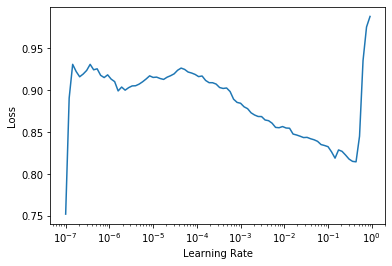

In [12]:
learn_c.lr_find()

In [13]:
lr = 1e-2
# lr *= bs/48  # Scale learning rate by batch size
n_epochs = 15
div = 10
cb = SaveModelCallback()

In [14]:
learn_c.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms, div=div)
learn_c.unfreeze()
lr /= 5
learn_c.fit_one_cycle(2*n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div, cbs=cb)

epoch,train_loss,valid_loss,accuracy,f1_score,matthews_corrcoef,time
0,0.738895,0.498474,0.818082,0.794746,0.613671,00:04
1,0.686634,0.450831,0.827425,0.769604,0.546625,00:04
2,0.656627,0.454125,0.838417,0.777243,0.570875,00:04
3,0.662719,0.448049,0.841715,0.806133,0.613073,00:04
4,0.674988,0.431780,0.834295,0.786769,0.575071,00:05
5,0.634839,0.432048,0.827700,0.768863,0.546228,00:04
6,0.645993,0.443274,0.827700,0.777687,0.557170,00:04
7,0.655057,0.416070,0.850234,0.805843,0.614161,00:04
8,0.625729,0.436224,0.825776,0.753029,0.531782,00:04
9,0.625903,0.432621,0.836219,0.779881,0.568884,00:04


epoch,train_loss,valid_loss,accuracy,f1_score,matthews_corrcoef,time
0,0.605433,0.420640,0.849409,0.810733,0.621526,00:09
1,0.625682,0.418726,0.844188,0.793568,0.593203,00:09
2,0.591931,0.414802,0.846661,0.797500,0.600460,00:08
3,0.587249,0.418422,0.855730,0.818959,0.637949,00:09
4,0.535614,0.407157,0.857378,0.818980,0.638417,00:08
5,0.514627,0.410892,0.853256,0.808250,0.620152,00:08
6,0.505335,0.404114,0.861775,0.821893,0.645558,00:08
7,0.492599,0.404365,0.863149,0.826914,0.654105,00:08
8,0.484357,0.406495,0.862600,0.821692,0.646063,00:08
9,0.488198,0.397891,0.867546,0.839686,0.681550,00:09


In [15]:
# learn_c.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms, div=div)
# for i in [2, 3, 4, 5]:
#     learn_c.freeze_to(-i)
#     learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div)
#     lr /= 3
#     if i == 5:
#         learn_c.fit_one_cycle(n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div, cbs=cb)

In [16]:
test_splits = RandomSplitter(0.0)(test_df)
x_tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
test_dsrc = Datasets(test_df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=test_splits, dl_type=SortedDL)
test_data = test_dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
                                  cache=2048, num_workers=8, pin_memory=True)
learn_c.validate(dl=test_data[0])

(#4) [0.35467854142189026,0.9102447628974915,0.8491347807765904,0.6988885253505979]

In [23]:
# [0.35467854142189026,0.9102447628974915,0.8491347807765904,0.6988885253505979]
# learn_c.save(f'{lang}clas_{tok}_{data_format}_binary_fwd')

In [18]:
from fastai2.interpret import *
interp = ClassificationInterpretation.from_learner(learn_c)
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"▁xxbos ▁ב וקר ▁טוב ▁, ▁אדוני ▁נשיא ▁מדינת ▁ישראל ▁. ▁אתה ▁לא ▁יכול ▁ל התחיל ▁לה בין ▁איזה ▁אושר ▁נפל ▁ב חלק י ▁כאש ר ▁ צפי תי ▁ב זכיית ך ▁בתפקיד ▁הלאומי ▁במדינה ▁. ▁ אני ▁חייב ת ▁לומר ▁לך ▁לפני ▁הכל ▁, ▁ש איש ית ▁בשל ▁המי אוס ▁ש יצר ▁ xxunk ▁בתפקיד ▁, ▁למרות ▁היו קרה ▁ הרבה ▁( ▁ול דעת י ▁המזו י י פת ▁) ▁לה ▁הוא ▁ זכה ▁ב רחב י ▁עולם ▁, ▁הייתי ▁בעד ▁ב יט ול ▁התפקיד ▁הזה ▁. ▁הכל ▁וב לב ד ▁שלא ▁תחז ור ▁על ▁עצמה ▁תקו פה ▁זו ▁של ▁שבע ▁השני ם ▁האחרונות ▁ה מגיע ות ▁ל קי צ ן ▁. ▁היו ▁לי ▁רגע ▁ חשש ▁ו דאג ה ▁בזמן ▁הסיב וב ▁השני ▁ש פ גו ▁עם ▁ה קרא ת ▁התוצא ות ▁, ▁תודה ▁לא ל ▁. ▁כפי ▁שאמרת ▁, ▁אתה ▁איש ▁העם ▁, ▁אתה ▁גם ▁איש ▁של ▁ירושלים",1,0,0.9928353428840637,4.692028522491455
1,▁xxbos ▁גדול ▁אתה ▁רבי ע ▁רבי ע ▁אהבתי ▁מאוד ▁כל ▁הכבוד,1,0,0.9730993509292603,3.4361870288848877
2,▁xxbos ▁אמיר ▁למה ▁אתה ▁מגל ה ▁לו ▁את ▁מה ▁ש הוא ▁יודע ▁אך ▁באישיות ▁שלו ▁ריבלין ▁יודע ▁ל עלות ▁מעל ▁א גו ▁בא ציל ות,0,1,0.9721226692199707,3.402358055114746
3,▁xxbos ▁ פיך ▁ל שמים ▁כבוד ▁הנשיא ▁הנבחר ▁בהצלחה xxunk ▁xxrep ▁6 ▁!,1,0,0.9718227982521057,3.3922080993652344
4,▁xxbos ▁רוצים ▁נקמ ▁xxrep ▁5 ▁ה,1,0,0.9575309753417969,3.0032005310058594
5,"▁xxbos ▁פי קו ח ▁נפש ▁, ▁פי קו ח ▁נפש ▁, ▁ה קד מת ▁ר פ ואה ▁למ כה ▁: ▁כבוד ▁יו "" ר ▁הכנסת ▁, ▁מה ▁ה עמד ה ▁שלך ▁ב עניין ▁? ▁אחוז י ▁התח ל ואה ▁בחיפ ה ▁מה גב ו ה ים ▁בארץ ▁! ▁הרש ויות ▁טוע נות ▁ש אין ▁לזה ▁קשר ▁למ פעל ים ▁. ▁כל ▁בר ▁דעת ▁מבין ▁שזה ו ▁שקר ▁של ▁אנשים ▁בעלי ▁ אינטרס ים ▁http s : ▁/ ▁/ ▁xxrep ▁3 ▁w ▁. fa ce book . com ▁/ ▁ even ts ▁/ ▁1 45 0 4 45 0 3 1 8 7 612 2 ▁/",1,0,0.9550244212150574,2.948854446411133
6,"▁xxbos ▁הרס ת ▁רובי ▁, ▁הרס ת ▁את ▁כל ▁ה הערכה ▁אליך",1,0,0.9544559121131897,2.9369523525238037
7,"▁xxbos ▁ראיתי ▁ש כבר ▁ל יק ק ת ▁לש "" ס ▁. ▁ אין ▁ספק ▁שאתה ▁מתאים ▁לנשיאות",1,0,0.9508811831474304,2.8653547763824463
8,▁xxbos ▁הכר תי ▁בנות ▁כאלה ▁... ▁היא ▁שרמוטה ▁א רס ית ▁מגעיל ה ▁ש שות ה ▁ו ו דק ה ▁בלי ▁קר ח xxunk ▁והוא ▁xxrep ▁4 ▁ח ▁הוא ▁עוד ▁יש בור ▁לה ▁את ▁ה פנים ▁כל ▁יום ▁שהיא ▁תקו ם ▁בב וקר ▁. ▁בהצלחה ▁שיהיה ▁כן ▁!,1,0,0.9497185945510864,2.8431944847106934
9,▁xxbos ▁בני ▁ש ט ן ▁... ▁יהי ▁זכרו ▁ברוך ▁.,1,0,0.9476673007011414,2.8053157329559326


In [19]:
train_df.iloc[splits[1]].iloc[np.array(interp.dl.get_idxs())[interp.top_losses(k=10)[1]]]

,text,label,is_valid
8120,"בוקר טוב , אדוני נשיא מדינת ישראל . אתה לא יכול להתחיל להבין איזה אושר נפל בחלקי כאשר צפיתי בזכייתך בתפקיד הלאומי במדינה . אני חייבת לומר לך לפני הכל , שאישית בשל המיאוס שיצר קודמך בתפקיד , למרות היוקרה הרבה ( ולדעתי המזוייפת ) לה הוא זכה ברחבי עולם , הייתי בעד ביטול התפקיד הזה . הכל ובלבד שלא תחזור על עצמה תקופה זו של שבע השנים האחרונות המגיעות לקיצן . היו לי רגע חשש ודאגה בזמן הסיבוב השני שפגו עם הקראת התוצאות , תודה לאל . כפי שאמרת , אתה איש העם , אתה גם איש של ירושלים , איש של ארץ ישראל ובעיקר אתה צנוע , ענו ואהוב . אנא , אל תשית ליבך לדברים שיאמר לך הנשיא היוצא , אלא אם יהיו הם בנושא...",1,False
9603,גדול אתה רביע רביע אהבתי מאוד כל הכבוד,1,False
6975,אמיר למה אתה מגלה לו את מה שהוא יודע אך באישיות שלו ריבלין יודע לעלות מעל אגו באצילות,0,False
1783,פיך לשמים כבוד הנשיא הנבחר בהצלחה בתפקידך !!!!!!,1,False
8122,רוצים נקמההההה,1,False
616,"פיקוח נפש , פיקוח נפש , הקדמת רפואה למכה : כבוד יו""ר הכנסת , מה העמדה שלך בעניין ? אחוזי התחלואה בחיפה מהגבוהים בארץ ! הרשויות טוענות שאין לזה קשר למפעלים . כל בר דעת מבין שזהו שקר של אנשים בעלי אינטרסים https://www.facebook.com/events/1450445031876122/",1,False
4921,"הרסת רובי , הרסת את כל ההערכה אליך",1,False
10101,"ראיתי שכבר ליקקת לש""ס . אין ספק שאתה מתאים לנשיאות",1,False
5287,הכרתי בנות כאלה ... היא שרמוטה ארסית מגעילה ששותה וודקה בלי קרח .... והוא חחחח הוא עוד ישבור לה את הפנים כל יום שהיא תקום בבוקר . בהצלחה שיהיה כן !,1,False
177,בני שטן ... יהי זכרו ברוך .,1,False


In [20]:
#test.loc[np.array(interp.dl.get_idxs())[interp.top_losses(k=10)[1]]]

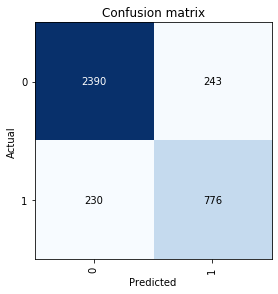

In [21]:
interp.plot_confusion_matrix()

In [22]:
# 0 - positive
# 1 - negative
# 2 - neutral